### In this notebook I will try to make a simple NN interpretable. For this task I chosed the MNIST dataset and a simple 3-layer neural network.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import einops
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor()) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

In [3]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss.detach().cpu()

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss

I used a fully connected neural network with 2 hidden layers. I used the Adam optimizer and the  crossentropy loss function.

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(784, 256)
        self.layer3 = nn.Linear(256, 64)
        self.layer4 = nn.Linear(64, 10)
        self.layers = [self.layer1, self.layer3, self.layer4]


    def forward(self, x):
        x = self.flatten(x)
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x
    

In [5]:
model = Model()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_loss = 0
test_loss = 0

for t in tqdm(range(epochs), desc="Epochs"):
    # print(f"\nEpoch {t+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer)
    test_loss = test(test_loader, model, loss_fn=loss_fn)
    tqdm.write(f"Train Loss: {float(train_loss):>8f}")
    tqdm.write(f"Test Loss: {test_loss:>8f}")

print("-----------------Done!-----------------")
print(f"Train Loss: {float(train_loss):>8f}")
print(f"Test Loss: {test_loss:>8f}")
print("Done!")


Epochs:  20%|██        | 1/5 [00:07<00:28,  7.24s/it]

Train Loss: 0.211777
Test Loss: 0.001417


Epochs:  40%|████      | 2/5 [00:14<00:22,  7.45s/it]

Train Loss: 0.101095
Test Loss: 0.000931


Epochs:  60%|██████    | 3/5 [00:22<00:14,  7.47s/it]

Train Loss: 0.089456
Test Loss: 0.000852


Epochs:  80%|████████  | 4/5 [00:29<00:07,  7.45s/it]

Train Loss: 0.136927
Test Loss: 0.000789


Epochs: 100%|██████████| 5/5 [00:37<00:00,  7.45s/it]

Train Loss: 0.030437
Test Loss: 0.000607
-----------------Done!-----------------
Train Loss: 0.030437
Test Loss: 0.000607
Done!


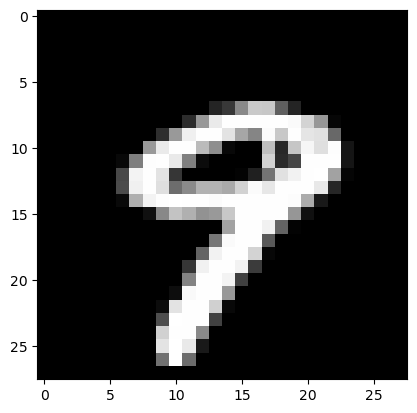

Label: 9, Predicted: tensor([9], device='cuda:0')


In [8]:
# Some test codes
def predict(model, input):
    model.eval()
    with torch.no_grad():
        pred = model(input)
        return pred.argmax(1)
    
input, label = test_data[9]
plt.imshow(input[0], cmap='gray')
plt.show()
print(f"Label: {label}, Predicted: {predict(model, input.unsqueeze(0).to(device))}")


In order to first check the interpretability of this model I'll do some visualization stuff.

First, I will visualize the activations of the hidden layers to examine two aspects: 1. The sparsity of the model, and 2. The distribution of the activations.

If the activations are sparse and the distribution varies with different inputs, we can infer that the model possesses a certain level of interpretability.

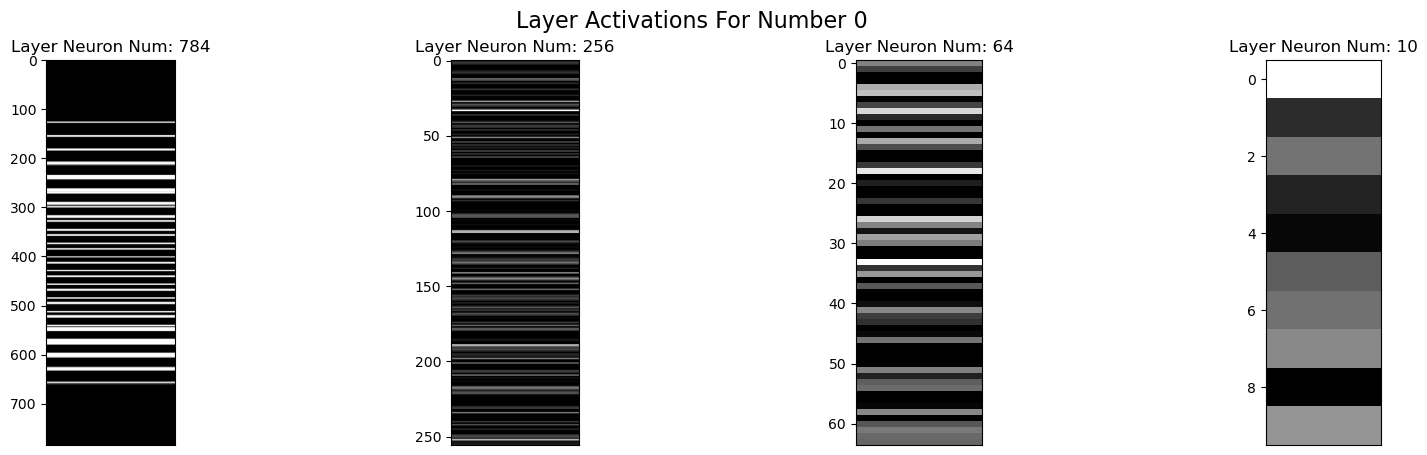

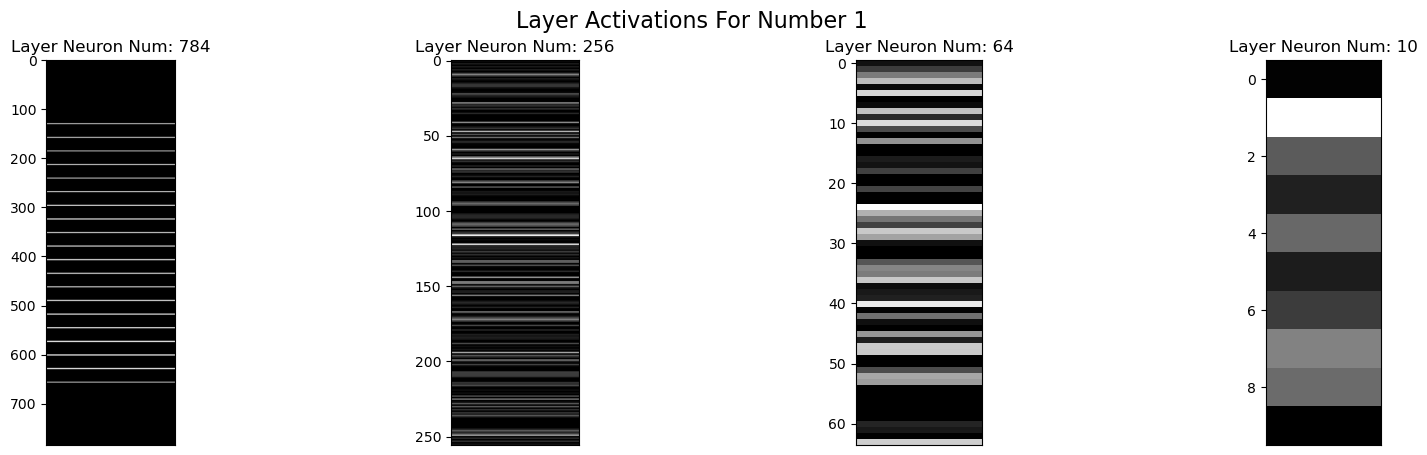

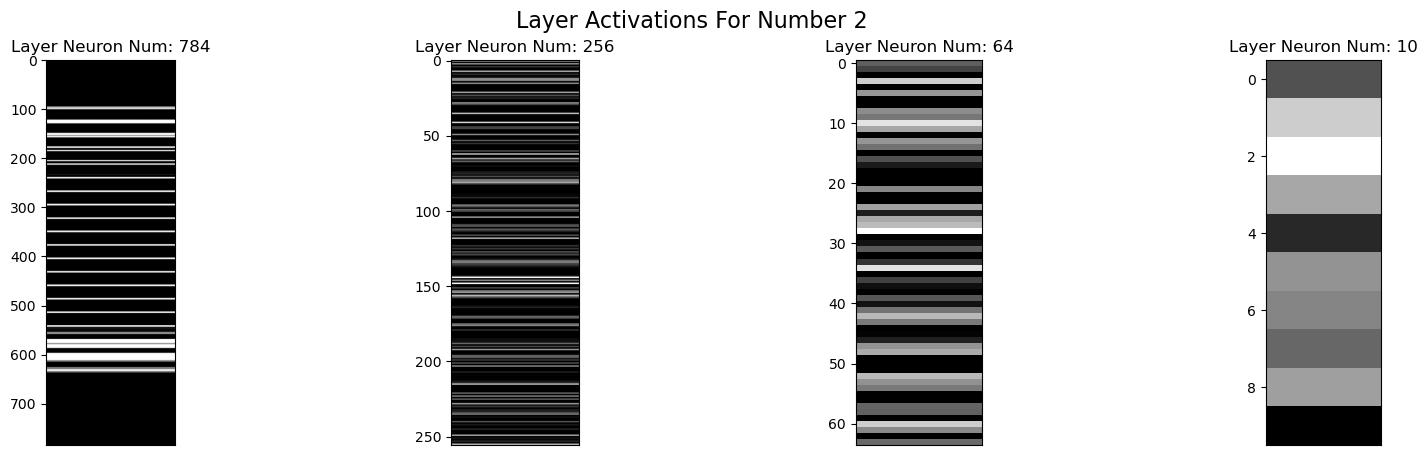

In [9]:
# Initialize a dictionary to hold lists of images for each label
images_by_label = {i: [] for i in range(10)}

# Desired number of images per label
images_per_label = 5

for item in test_data:
    input, label = item
    # Check if the current label's list has less than the desired number of images
    if len(images_by_label[label]) < images_per_label:
        images_by_label[label].append(item)

# images_by_label [number] [one of the 5 images] [0 for image, 1 for label]

def layer_output(input, layer_num, model):
    model.eval()
    with torch.no_grad():
        input = input.unsqueeze(0).to(device)
        flatten_out = model.flatten(input)
        linear_out = flatten_out
        for i in range(0, layer_num):
            linear_out = model.layers[i](linear_out)
            if i != len(model.layers)-1:
                linear_out = F.relu(linear_out)
        return linear_out        

def viz_layer_out(input, model, layer_num, ax=None):
   
    if ax == None:
        ax = plt.gca()
    linear_out = layer_output(input, layer_num, model)
    unsqueezed_linear_out = linear_out.cpu().detach().unsqueeze(-1)
    expand_c = int(unsqueezed_linear_out.shape[1]/3)
    result_tensor = unsqueezed_linear_out.repeat(1, 1, expand_c)[0,:,:]
    ax.imshow(result_tensor, cmap='gray')
    ax.set_title(f"Layer Neuron Num: {result_tensor.shape[0]}")
    ax.set_xticks([])

def viz_layers(input,model,layer_num, label):
    # Determine the number of plots
    n = layer_num 

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, n, figsize=(n*5, 5))  # Adjust figsize as needed
    fig.suptitle(f"Layer Activations For Number {label}", fontsize=16)

    for i, ax in enumerate(axs):
        viz_layer_out(input, model, i, ax)

    plt.show()


for i in range(0,3):
    # print(f"Number: {i}")
    viz_layers(images_by_label[i][0][0], model, 4,images_by_label[i][0][1])


To examine the interpretability of the model, I first analyzed the activations of the layers, which is the simplest method. If different neurons were activated for different inputs, we could interpret the model. In more technical terms, I assessed whether the neurons in the model were polysemantic or monosemantic and provided commentary on the model's interpretability based on these findings.

However, as the visualizations showed, the activations were not sparse, and the distribution was similar across all inputs, making it difficult to distinguish between them visually. This indicated that visualizing hidden layer activations was not an effective method for understanding the model's interpretability.

So instead, I focused on quantitative measures such as "matching indexes" and cosine similarity between activation vectors to gain insights into the model's behavior across different inputs. This approach allowed for a more objective comparison of how the model processed various inputs, potentially uncovering patterns or biases in the learned representations.

Matching indexes: the number of neurons whose positions are the same from the neurons with the highest activation in the layers given two different inputs.

In [10]:
def find_matching_activations(vector1, vector2, threshold_percentile):
    vector1 = vector1.flatten()
    vector2 = vector2.flatten()
    # Combine vectors
    combined = torch.cat((vector1, vector2))

    # Calculate the threshold value based on the percentile
    k = int(len(combined) * (threshold_percentile / 100.0))
    threshold = torch.kthvalue(combined, k).values
    
    # Find indexes of values above the threshold in each vector
    indexes_above_threshold_v1 = torch.where(vector1 > threshold)[0]
    indexes_above_threshold_v2 = torch.where(vector2 > threshold)[0]
    
    # Convert tensors to sets for intersection
    set_v1 = set(indexes_above_threshold_v1.tolist())
    set_v2 = set(indexes_above_threshold_v2.tolist())
    
    # Find matching indexes in both vectors
    matching_indexes = list(set_v1.intersection(set_v2))

    # what percentage of the activations are matching
   
    matching_percent = (len(matching_indexes)/(min(len(indexes_above_threshold_v1),len(indexes_above_threshold_v2))) * 100) if len(matching_indexes) > 0 else 0
    return matching_indexes, matching_percent

num_1 = 2
num_2 = 5
layer_num = 0
vector1 = layer_output(images_by_label[num_1][4][0], layer_num, model)
vector2 = layer_output(images_by_label[num_2][2][0], layer_num, model)

print(f"Number {num_1}, Layer: {layer_num}")
print(f"Number {num_2}, Layer: {layer_num}")

print("\nCalculating Matching Indexes...")
matching_indexes,_ = find_matching_activations(vector1, vector2, 60)
print("Matching Indexes:", f"{matching_indexes[:10]}... and more" if len(matching_indexes) > 10 else matching_indexes)
print("Number of Matching Indexes:", len(matching_indexes))

print("\nCalculating cosine similarity...")
cosine_similarity = F.cosine_similarity(vector1, vector2, dim=1)
print("Cosine Similarity:", cosine_similarity.item())

Number 2, Layer: 0
Number 5, Layer: 0

Calculating Matching Indexes...
Matching Indexes: [520, 521, 522, 402, 403, 404, 405, 408, 156, 157]... and more
Number of Matching Indexes: 51

Calculating cosine similarity...
Cosine Similarity: 0.2623065710067749


To make everything more clean and seeing everything at once, I created a heatmap visualization of the matching index percentages between different pairs of numbers for a specific layer. This approach allows for an immediate visual grasp of how similar the activations are across different inputs, highlighting patterns of similarity and difference within the model's internal representations.

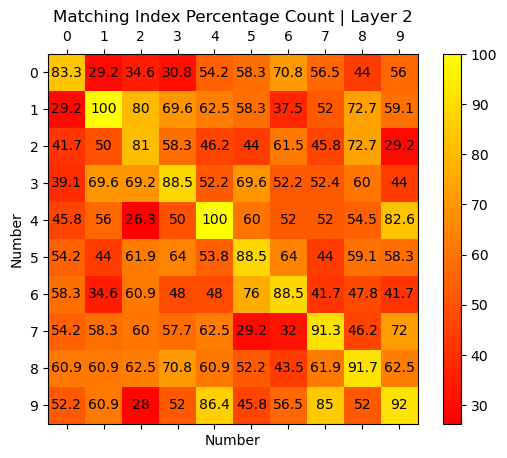

In [11]:
layer_num = 2
threshold_percentile = 60

matching_index_matrix = np.zeros((10, 10), dtype=object)
matching_index_percentage_matrix = np.zeros((10, 10), dtype=object)

for i in range(10):
    for j in range(10):
        vector1 = layer_output(images_by_label[i][3][0], layer_num, model)
        vector2 = layer_output(images_by_label[j][2][0], layer_num, model)
        matching_indexes = find_matching_activations(vector1, vector2, threshold_percentile)
        matching_index_percentage_matrix[i][j] = matching_indexes[1]
        matching_index_matrix[i][j] = len(matching_indexes[0])


fig, ax = plt.subplots()
matching_index_matrix_np = np.array(matching_index_percentage_matrix).astype(float)
cax = ax.matshow(matching_index_matrix_np, cmap='autumn')

# Add colorbar to interpret the values
fig.colorbar(cax)

# Set ticks and labels for both axes
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(10))

for i in range(10):
    for j in range(10):
        formatted_value = f"{matching_index_matrix_np[i, j]:.3g}"
        ax.text(j, i, formatted_value,
                ha="center", va="center", color="black")

# Label axes
ax.set_xlabel('Number')
ax.set_ylabel('Number')

# Title for the heatmap
ax.set_title(f'Matching Index Percentage Count | Layer {layer_num}')

plt.show()

The model is not interpretable, as most neurons are polysemantic. 
To solve this problem with model architecture or training methods, we can use L1 regularization to increase sparsity and increase the number of neurons. However, using too many neurons can lead to overfitting. In the other side if we increase sparsity by using fewer neurons, as shown in the 'Toy Models of Superposition' article, 'superposition' may occurs because there are not enough neurons and the interpretability of the model decreases as a result.

Therefore, I will refer to Anthropic's article and use the suggested methods from there.

https://transformer-circuits.pub/2023/monosemantic-features/index.html#appendix-autoencoder

So down below I'll try to implement the techniques mentioned in the paper which is using a Sparse Overcomplete Autoencoder. Because in the paper the authors are doing tests on a Language model and have massive data and computing power and I dont have those I'll try to implement the techniques on a smaller scale so that would probably not work as expected but I'll try to do my best. 

In [10]:
# creating sparse overcomplete autoencoder
class SparseOvercompleteAutoEncoder(nn.Module):
    def __init__(self,input_size, latent_size, lambda_l1):
        super(SparseOvercompleteAutoEncoder, self).__init__()
        self.flatten = nn.Flatten()
        self.lambda_l1 = lambda_l1
        self.W_e = nn.Parameter(torch.randn(latent_size, input_size))
        self.b_e = nn.Parameter(torch.randn(latent_size))
        self.W_d = nn.Parameter(torch.randn(input_size, latent_size))
        self.b_d = nn.Parameter(torch.randn(input_size))



        nn.init.kaiming_uniform_(self.W_e, a=nn.init.calculate_gain('relu'))
        nn.init.kaiming_uniform_(self.W_d, a=nn.init.calculate_gain('linear'))

        nn.init.constant_(self.b_e, 0)
        nn.init.constant_(self.b_d, 0)

    def forward(self, x, return_latent=False):
        x_ = x - self.b_d
        f = F.relu(x_ @ self.W_e.T + self.b_e)
        x_hat = f @ self.W_d.T + self.b_d
        if return_latent:
            return x_hat, f
        return x_hat


In [11]:
def loss_function(x, x_hat, f, lambda_l1):
    mse_loss = F.mse_loss(x_hat, x, reduction='mean')
    l1_loss = lambda_l1 * torch.norm(f, p=1)
    return mse_loss + l1_loss

In [12]:
def get_activations(model, layer_num, data_loader, device):
    activations = []

    # Define a hook function
    def hook(model, input, output):
        activations.append(output.detach())

    # Attach the hook to the specified layer
    handle = list(model.children())[layer_num].register_forward_hook(hook)

    # Pass data through the model to collect activations
    for X, _ in data_loader:
        X = X.to(device)
        model(X)

    # Remove the hook after collecting activations
    handle.remove()

    # Concatenate all collected activations
    activations = torch.cat(activations, dim=0)
    return activations.cpu()

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor()),
    batch_size=512, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor()),
    batch_size=512, shuffle=True)

layer_num = 1
train_activations = get_activations(model, layer_num, train_loader, device)
test_activations = get_activations(model, layer_num, test_loader, device)

print(train_activations.shape, test_activations.shape)



torch.Size([60000, 256]) torch.Size([10000, 256])


As I do have 60 000 samples I can't use numbers like 8 million activation as it is mentioned in the paper. This would probably cause a lot of problem but I'll try to implement the techniques on a smaller scale and later solve the issues step by step.

In [25]:
def resample_neurons(model, dataset, step, interval=125):
    if step % interval == 0 :
        # print("Resampling dead neurons...")
        # Identify dead neurons
        with torch.no_grad():
            dead_neurons = (torch.sum(dataset, dim=0) == 0)
            dead_neurons_indices = torch.nonzero(dead_neurons).squeeze()
            
            if len(dead_neurons_indices) > 0:
                subset_indices = np.random.choice(len(dataset), 128)
                subset = dataset[subset_indices]
                
                # Compute loss on subset
                x_subset = torch.tensor(subset, dtype=torch.float32)
                x_hat_subset, _ = model(x_subset)
                losses = F.mse_loss(x_hat_subset, x_subset, reduction='none').sum(dim=1)
                
                probabilities = (losses / losses.sum()).pow(2)
                
                # Resample neurons
                for neuron_idx in dead_neurons_indices:
                    sample_idx = np.random.choice(len(x_subset), p=probabilities.numpy())
                    resample_input = x_subset[sample_idx]
                    
                    # Renormalize and set new dictionary vector
                    new_dict_vector = resample_input / resample_input.norm()
                    model.W_d.data[neuron_idx] = new_dict_vector
                    
                    # Reset corresponding encoder vector
                    avg_norm = model.W_e.data.mean(dim=1).norm() * 0.2
                    new_encoder_vector = new_dict_vector / new_dict_vector.norm() * avg_norm
                    model.W_e.data[:, neuron_idx] = new_encoder_vector
                    model.b_e.data[neuron_idx] = 0
                    
                    # Reset Adam optimizer parameters (done in training loop)
                    
def train_autoencoder(model, train_data, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data), batch_size=256, shuffle=True)
    
    for epoch in tqdm(range(epochs), desc="Epochs"):
        total_loss = 0
        for step, (x,) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")):
            optimizer.zero_grad()
            x = x.float().to(device)
            x_hat, f = model(x, return_latent=True)
            loss = loss_function(x, x_hat, f, model.lambda_l1)
            loss.backward()
            
            with torch.no_grad():
                model.W_d.grad -= model.W_d * (model.W_d.grad * model.W_d).sum(dim=0)
                
            optimizer.step()
            
            total_loss += loss.item()
            resample_neurons(model, train_data, epoch * len(train_loader) + step)
        
        tqdm.write(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader)}')

# def train_autoencoder2(model, train_data, epochs=100, lr=1e-3, batch_size=256):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    # Wrap data in DataLoader for easy batch processing
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data), batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        total_loss = 0
        for step, (x,) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.float()
            x = x.to(device)
            x_hat, f = model(x, return_latent=True)
            loss = loss_function(x, x_hat, f, model.lambda_l1)
            loss.backward()
            
            # Gradient step with proper decoder normalization
            with torch.no_grad():
                model.W_d.grad -= model.W_d * (model.W_d.grad * model.W_d).sum(dim=0)
                
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader)}')


In [26]:
# Example usage
input_dim = 256  # For example, if input is 28x28 images
hidden_dim = 256*256  # Overcomplete hidden layer
lambda_l1 = 0.006  # L1 regularization parameter


autoencoder = SparseOvercompleteAutoEncoder(input_dim, hidden_dim, lambda_l1)


# Train the model
train_autoencoder(autoencoder, train_activations, epochs=50, lr=1e-3)

Epochs:   2%|▏         | 1/50 [00:12<10:00, 12.26s/it]

Epoch [1/50], Loss: 1091.073858441698


Epochs:   4%|▍         | 2/50 [00:24<09:48, 12.25s/it]

Epoch [2/50], Loss: 2.779680166853235


Epochs:   6%|▌         | 3/50 [00:36<09:36, 12.26s/it]

Epoch [3/50], Loss: 2.4947809726633925


Epochs:   8%|▊         | 4/50 [00:49<09:26, 12.31s/it]

Epoch [4/50], Loss: 2.4039261696186474


Epochs:  10%|█         | 5/50 [01:01<09:16, 12.36s/it]

Epoch [5/50], Loss: 2.368628197527946


Epochs:  12%|█▏        | 6/50 [01:14<09:05, 12.39s/it]

Epoch [6/50], Loss: 2.3522644499514964


Epochs:  14%|█▍        | 7/50 [01:26<08:55, 12.46s/it]

Epoch [7/50], Loss: 2.3458888327821774


Epochs:  16%|█▌        | 8/50 [01:39<08:47, 12.57s/it]

Epoch [8/50], Loss: 2.3420550985539212


Epochs:  18%|█▊        | 9/50 [01:53<08:50, 12.94s/it]

Epoch [9/50], Loss: 2.3406732995459376


Epochs:  20%|██        | 10/50 [02:06<08:47, 13.19s/it]

Epoch [10/50], Loss: 2.3390671740186977


Epochs:  22%|██▏       | 11/50 [02:20<08:41, 13.36s/it]

Epoch [11/50], Loss: 2.3393749439969977


Epochs:  24%|██▍       | 12/50 [02:34<08:32, 13.48s/it]

Epoch [12/50], Loss: 2.338488151672039


Epochs:  26%|██▌       | 13/50 [02:48<08:22, 13.59s/it]

Epoch [13/50], Loss: 2.3374816914822194


Epochs:  28%|██▊       | 14/50 [03:02<08:11, 13.64s/it]

Epoch [14/50], Loss: 2.3365905802300637


Epochs:  30%|███       | 15/50 [03:15<07:58, 13.68s/it]

Epoch [15/50], Loss: 2.335560915317941


Epochs:  32%|███▏      | 16/50 [03:29<07:46, 13.71s/it]

Epoch [16/50], Loss: 2.3350923030934436


Epochs:  34%|███▍      | 17/50 [03:43<07:33, 13.73s/it]

Epoch [17/50], Loss: 2.334682767949206


Epochs:  36%|███▌      | 18/50 [03:57<07:19, 13.75s/it]

Epoch [18/50], Loss: 2.333558871898245


Epochs:  38%|███▊      | 19/50 [04:11<07:07, 13.79s/it]

Epoch [19/50], Loss: 2.3335947909253707


Epochs:  40%|████      | 20/50 [04:24<06:53, 13.80s/it]

Epoch [20/50], Loss: 2.3321816657451873


Epochs:  42%|████▏     | 21/50 [04:38<06:40, 13.80s/it]

Epoch [21/50], Loss: 2.3320739553329792


Epochs:  44%|████▍     | 22/50 [04:52<06:26, 13.81s/it]

Epoch [22/50], Loss: 2.330147688439552


Epochs:  46%|████▌     | 23/50 [05:06<06:12, 13.81s/it]

Epoch [23/50], Loss: 2.3299455013680967


Epochs:  48%|████▊     | 24/50 [05:20<05:59, 13.81s/it]

Epoch [24/50], Loss: 2.3297674158786204


Epochs:  50%|█████     | 25/50 [05:33<05:45, 13.81s/it]

Epoch [25/50], Loss: 2.3280925497095635


Epochs:  52%|█████▏    | 26/50 [05:47<05:32, 13.85s/it]

Epoch [26/50], Loss: 2.326972883305651


Epochs:  54%|█████▍    | 27/50 [06:01<05:18, 13.85s/it]

Epoch [27/50], Loss: 2.3242137208898015


Epochs:  56%|█████▌    | 28/50 [06:15<05:04, 13.84s/it]

Epoch [28/50], Loss: 2.3239822387695312


Epochs:  58%|█████▊    | 29/50 [06:29<04:50, 13.83s/it]

Epoch [29/50], Loss: 2.320526641480466


Epochs:  60%|██████    | 30/50 [06:43<04:36, 13.83s/it]

Epoch [30/50], Loss: 2.318877438281445


Epochs:  62%|██████▏   | 31/50 [06:57<04:22, 13.84s/it]

Epoch [31/50], Loss: 2.3162321476226158


Epochs:  64%|██████▍   | 32/50 [07:11<04:09, 13.89s/it]

Epoch [32/50], Loss: 2.3114092005060076


Epochs:  66%|██████▌   | 33/50 [07:24<03:55, 13.88s/it]

Epoch [33/50], Loss: 2.310698265724994


Epochs:  68%|██████▊   | 34/50 [07:38<03:42, 13.88s/it]

Epoch [34/50], Loss: 2.3053742591370927


Epochs:  70%|███████   | 35/50 [07:52<03:28, 13.87s/it]

Epoch [35/50], Loss: 2.3018634126541464


Epochs:  72%|███████▏  | 36/50 [08:06<03:14, 13.87s/it]

Epoch [36/50], Loss: 2.29707993953786


Epochs:  74%|███████▍  | 37/50 [08:20<03:00, 13.87s/it]

Epoch [37/50], Loss: 2.292247969038943


Epochs:  76%|███████▌  | 38/50 [08:34<02:46, 13.91s/it]

Epoch [38/50], Loss: 2.28796712591293


Epochs:  78%|███████▊  | 39/50 [08:48<02:32, 13.91s/it]

Epoch [39/50], Loss: 2.2810207701743916


Epochs:  80%|████████  | 40/50 [09:02<02:18, 13.90s/it]

Epoch [40/50], Loss: 2.2757727389639997


Epochs:  82%|████████▏ | 41/50 [09:16<02:05, 13.90s/it]

Epoch [41/50], Loss: 2.2697254069308017


Epochs:  84%|████████▍ | 42/50 [09:29<01:51, 13.89s/it]

Epoch [42/50], Loss: 2.2633485946249454


Epochs:  86%|████████▌ | 43/50 [09:43<01:37, 13.89s/it]

Epoch [43/50], Loss: 2.2550819148408605


Epochs:  88%|████████▊ | 44/50 [09:57<01:23, 13.94s/it]

Epoch [44/50], Loss: 2.2482623419863113


Epochs:  90%|█████████ | 45/50 [10:11<01:09, 13.92s/it]

Epoch [45/50], Loss: 2.2420735237446237


Epochs:  92%|█████████▏| 46/50 [10:25<00:55, 13.91s/it]

Epoch [46/50], Loss: 2.2317831922084728


Epochs:  94%|█████████▍| 47/50 [10:39<00:41, 13.90s/it]

Epoch [47/50], Loss: 2.225629633030993


Epochs:  96%|█████████▌| 48/50 [10:53<00:27, 13.90s/it]

Epoch [48/50], Loss: 2.217660284549632


Epochs:  98%|█████████▊| 49/50 [11:07<00:13, 13.90s/it]

Epoch [49/50], Loss: 2.2094545404961767


Epochs: 100%|██████████| 50/50 [11:21<00:00, 13.63s/it]

Epoch [50/50], Loss: 2.199464331281946


21845
torch.Size([1, 65536])
torch.Size([65536, 21845])


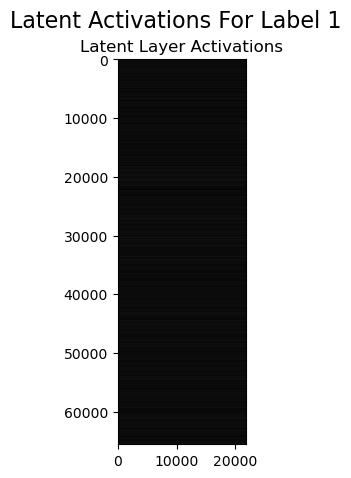

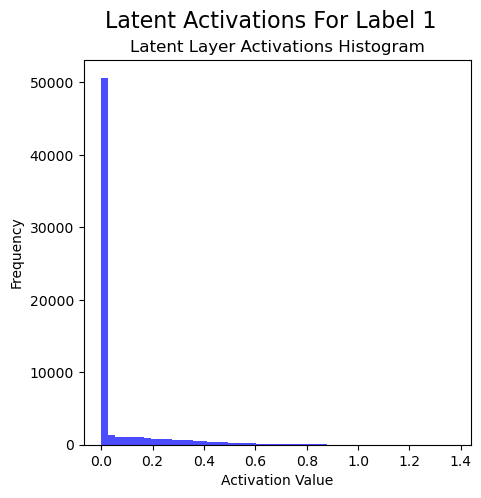

In [28]:
def latent_layer_output(input):
    autoencoder.eval()
    with torch.no_grad():
        input = input.unsqueeze(0)  # Assuming input is a single image
        input = input.to(device)
        output = layer_output(input, 1, model)
        _, latent_activations = autoencoder(output, return_latent=True)
        latent_activations = latent_activations.cpu().detach()
    return latent_activations

def viz_latent_layer(input, label):
    latent_activations = latent_layer_output(input)
    # Visualization
    fig, ax = plt.subplots(figsize=(5, 5))  # Adjust figsize as needed
    fig.suptitle(f"Latent Activations For Label {label}", fontsize=16)

    # Assuming the latent activations are 1D, reshape for visualization if necessary
    side_length = int(latent_activations.shape[1] / 3)
    print(side_length)
    print(latent_activations.shape)
    unsqueezed_linear_out = latent_activations.unsqueeze(-1)
    result_tensor = unsqueezed_linear_out.repeat(1, 1, side_length)[0,:,:]
    print(result_tensor.shape)
    ax.imshow(result_tensor, cmap='gray')
    ax.set_title("Latent Layer Activations")
    # ax.set_xticks([])
    # ax.set_yticks([])

    plt.show()

# histogram of the latent layer activations
def viz_latent_layer_hist(input, label):
    latent_activations = latent_layer_output(input)

    # Visualization
    fig, ax = plt.subplots(figsize=(5, 5))  # Adjust figsize as needed
    fig.suptitle(f"Latent Activations For Label {label}", fontsize=16)

    ax.hist(latent_activations.flatten(), bins=50, color='blue', alpha=0.7)
    ax.set_title("Latent Layer Activations Histogram")
    ax.set_xlabel("Activation Value")
    ax.set_ylabel("Frequency")

    plt.show()



# Visualize latent layer activations for label n
n = 1
if images_by_label[n]:  # Check if there are images for label n
    input_image, label = images_by_label[n][0]  # First image for label n
    viz_latent_layer(input_image, label)
    viz_latent_layer_hist(input_image, label)

Actually the sparsity is not bad but the loss is not decreasing so I think I have some problem I prolly do more research

https://transformer-circuits.pub/2023/monosemantic-features/index.html#appendix-autoencoder

# To be continued...